# Rerun Whole Process to Train Final Model

### Data Ingestion

In [2]:
import pandas as pd
preprocessed_data_path = 'preprocessed_data_with_text.csv'
preprocessed_data = pd.read_csv(preprocessed_data_path)

In [3]:
import os
data_dir = "./data_sources"
processed_file = os.path.join(data_dir, "01_cleaned_data.csv")
processed_df = pd.read_csv(processed_file)

processed_df['txn_date'] = pd.to_datetime(processed_df['txn_date'])


processed_df['year'] = processed_df['txn_date'].dt.year
processed_df['month'] = processed_df['txn_date'].dt.month
processed_df['day'] = processed_df['txn_date'].dt.day
processed_df['day_of_week'] = processed_df['txn_date'].dt.dayofweek  # Monday = 0, Sunday = 6

import numpy as np
import pandas as pd

df = processed_df.drop(columns=['txn_date'])


# Find the minimum value and compute the shift constant
min_value = df['amount'].min()  # Should be -9000
shift_constant = abs(min_value) + 1  # 9001

# Shift all values to be positive
df['amount'] = df['amount'] + shift_constant


### Data Preprocessing

In [4]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Columns to include
right_skewed_features = ['amount']
date_features = ['year', 'month', 'day', 'day_of_week']
text_feature = 'description'
target_column = 'category'
other_features = ['client_id', 'bank_id', 'account_id', 'txn_id','is_interested_investment', 'is_interested_build_credit',
       'is_interested_increase_income', 'is_interested_pay_off_debt',
       'is_interested_manage_spending', 'is_interested_grow_savings']

# 1️⃣ TF-IDF Vectorization for 'description'
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_text = vectorizer.fit_transform(df[text_feature].fillna(''))
X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())

# 2️⃣ Preprocessing for numerical & categorical columns
log_transformer = FunctionTransformer(np.log1p, validate=True)
mm_scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('log', log_transformer, right_skewed_features),
    ('mm', mm_scaler, date_features)
], sparse_threshold=0)  # Ensure dense output

X_other = preprocessor.fit_transform(df)
X_other_df = pd.DataFrame(X_other, columns=right_skewed_features + date_features)

# 3️⃣ Prepare untouched categorical/numerical features
untouched_df = df[other_features]

# 4️⃣ Target variable
y_df = pd.DataFrame(df[target_column])

# 5️⃣ **Create two separate datasets**
# 🔹 Dataset with TF-IDF processed text
X_combined_with_text = pd.concat([X_other_df, untouched_df, X_text_df], axis=1)
final_df_with_text = pd.concat([X_combined_with_text, y_df], axis=1)

# Display first few rows
print("Dataset with text processing:")
print(final_df_with_text.head())



Dataset with text processing:
     amount  year     month       day  day_of_week  client_id  bank_id  \
0  9.125268   0.0  1.000000  0.933333     0.666667          1        1   
1  9.125812   0.0  0.666667  0.433333     0.000000          1        1   
2  9.125268   0.0  1.000000  0.800000     0.000000          1        1   
3  9.124833   0.0  0.000000  0.033333     0.666667          1        1   
4  9.123525   0.0  0.000000  0.000000     0.500000          1        1   

   account_id  txn_id  is_interested_investment  ...  wius   wm   wv  www  \
0           1       4                         0  ...   0.0  0.0  0.0  0.0   
1           1       3                         0  ...   0.0  0.0  0.0  0.0   
2           1       5                         0  ...   0.0  0.0  0.0  0.0   
3           2       1                         0  ...   0.0  0.0  0.0  0.0   
4           2       2                         0  ...   0.0  0.0  0.0  0.0   

   xfer   yi  york  zelle  zip  category  
0   0.0  0.0   0.0 

In [5]:
from sklearn.model_selection import train_test_split

y = final_df_with_text['category']
X = final_df_with_text.drop(columns=['category'])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

In [6]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Define limits
# max_samples = 20000  # Upper limit for large categories
# min_samples = 1000   # Lower limit for small categories

# # Compute class distribution in training set
# class_counts = np.bincount(y_train)  # Count occurrences of each class
# classes = np.unique(y_train)

# # Define sampling strategies dynamically
# smote_strategy = {}
# undersample_strategy = {cls: int(count * 0.8) for cls, count in y_train.value_counts().items()}

# for cls, count in zip(classes, class_counts):
#     if count < min_samples:
#         smote_strategy[cls] = min_samples  # Oversample small classes to at least min_samples
#     elif count > max_samples:
#         undersample_strategy[cls] = max_samples  # Undersample large classes to max_samples

# # Ensure SMOTE doesn't fail due to low sample size
# k_neighbors = min(3, min(class_counts) - 1)  # Use a smaller k_neighbors if necessary

# # Apply SMOTE (oversampling) and RandomUnderSampler (undersampling)
# smote = SMOTE(sampling_strategy=smote_strategy, k_neighbors=k_neighbors)
# undersample = RandomUnderSampler(sampling_strategy=undersample_strategy)

# # Create resampling pipeline
# resampling_pipeline = Pipeline([
#     ('smote', smote),
#     ('undersample', undersample)
# ])

# # Apply resampling only on training data
# X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)


In [7]:
from lightgbm.sklearn import LGBMClassifier

rf_model = LGBMClassifier(
    n_estimators=2243,  # Number of boosting rounds
    learning_rate=0.02398841214295113,  # Learning rate
    max_depth=4,  # Maximum depth of the tree
    subsample=0.8852412682047747,  # Subsample ratio of the training set
    colsample_bytree=0.8083420730906675,  # Subsample ratio of columns when constructing each tree
    min_child_weight=7,  # Minimum sum of instance weight (Hessian) in a child
    num_leaves=645  # Maximum number of leaves in one tree
)

# Train the model
rf_model.fit(X_train, y_train)


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args,

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.225448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64911
[LightGBM] [Info] Number of data points in the train set: 165618, number of used features: 514
[LightGBM] [Info] Start training from score -3.820451
[LightGBM] [Info] Start training from score -6.476176
[LightGBM] [Info] Start training from score -8.881945
[LightGBM] [Info] Start training from score -3.694559
[LightGBM] [Info] Start training from score -7.112164
[LightGBM] [Info] Start training from score -4.395754
[LightGBM] [Info] Start training from score -2.631215
[LightGBM] [Info] Start training from score -4.861263
[LightGBM] [Info] Start training from score -4.046353
[LightGBM] [Info] Start training from score -6.628367
[LightGBM] [Info] Start training from score -2.997291
[LightGBM] [Info] Start training from score -8.233

LGBMClassifier(colsample_bytree=0.8083420730906675,
               learning_rate=0.02398841214295113, max_depth=4,
               min_child_weight=7, n_estimators=2243, num_leaves=645,
               subsample=0.8852412682047747)

In [9]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


In [10]:
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics for validation set
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
val_precision = precision_score(y_val, y_val_pred, average='weighted')
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_accuracy = accuracy_score(y_val, y_val_pred)

# Calculate metrics for test set
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the metrics
print("Validation Metrics:")
print(f"F1 Score: {val_f1:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"Accuracy: {val_accuracy:.4f}")
print()
print("Test Metrics:")
print(f"F1 Score: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")
print("-" * 50)


Validation Metrics:
F1 Score: 0.8738
Precision: 0.8798
Recall: 0.8750
Accuracy: 0.8750

Test Metrics:
F1 Score: 0.8720
Precision: 0.8784
Recall: 0.8734
Accuracy: 0.8734
--------------------------------------------------


c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
class_df = pd.read_csv("label_mappings.csv")

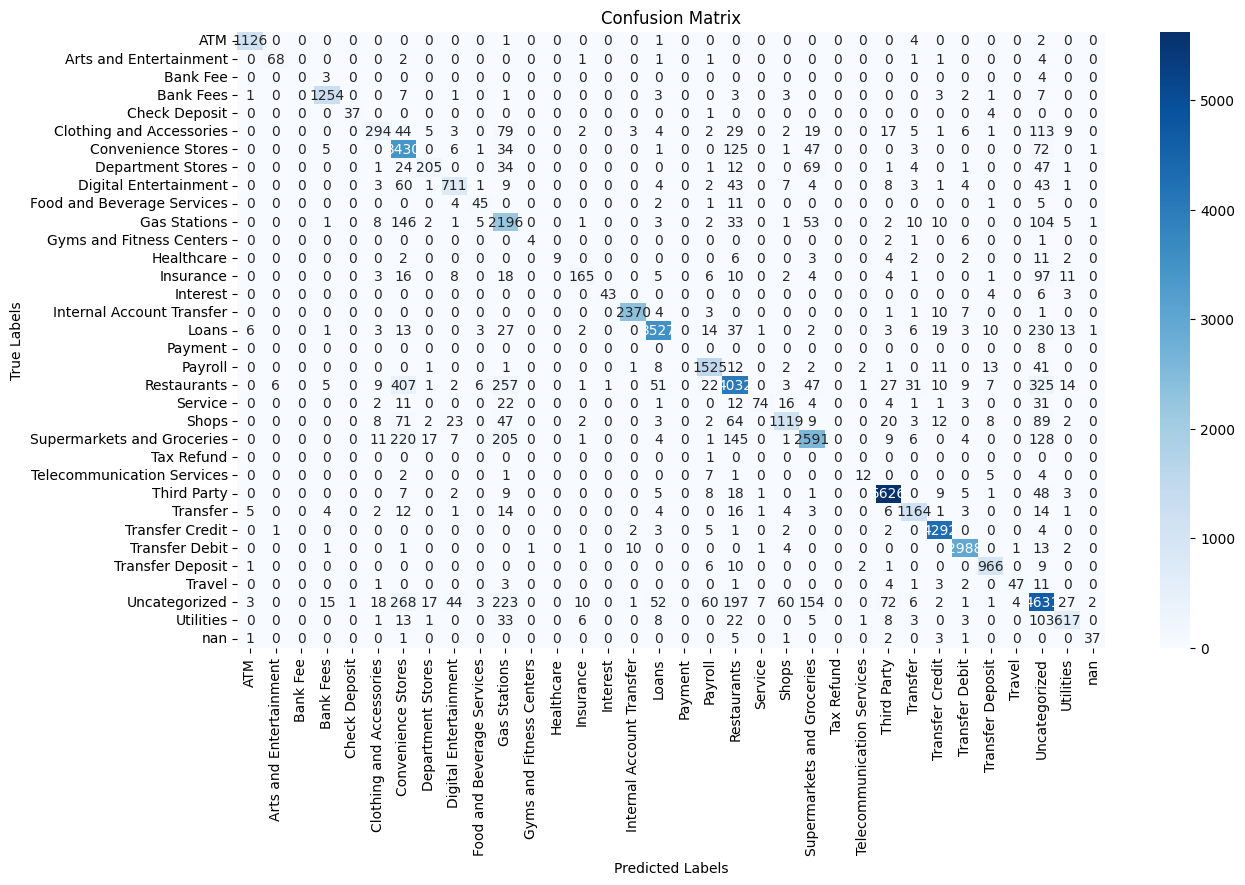

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_test_pred)
# Define class labels (modify as per your dataset)
class_labels = class_df["Original_Label"]  # Change based on your actual classes

plt.figure(figsize=(14, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
file_path = "plot.png"
plt.savefig(file_path)

### Model Tracking With MLFlow

In [13]:
import mlflow

# Set MLflow tracking URI & Experiment
mlflow.set_tracking_uri("http://127.0.0.1:8080")  
mlflow.set_experiment("Transaction Classification")

<Experiment: artifact_location='mlflow-artifacts:/715835200665664301', creation_time=1739038980493, experiment_id='715835200665664301', last_update_time=1739038980493, lifecycle_stage='active', name='Transaction Classification', tags={'mlflow.sharedViewState.60b5838b3c07b10d688fd52b4dd6c37593b139dcfb12d21877e12fcb552682f6': 'deflate;eJxdUl1PwzAM/CsozxOC176VMT7EhlA3JqQJbVnirZbSpIqdsYL233HXQQePPt/5nHO+FIGOprxDxxBVptRAhWgh3jRP0EitmSOuEwNdEuvIS8YKelJORmUb7QgG6tifte1M5eOxkBxuwDTGwe/43DDuWr3VrAmYfjqL94GqggU3h0gYfK9w7qJInkRD4MAw2GFwqRIkW5yvt5qGFA2shHiOTtqh9B+97exXSmyjTB/ta+0tWJV9HTrkBb1v68WJ8YDWgu/rORKu0SE3E133so7Wmsrud4/FdLa8vloWr89T2WCH8DHRe6zwsx19yk1kYyT+MTihSLkxkrJkUcAx7TNJIriPIdVg59oloEc/LCV8iYRjkn6JFkZVzc1feNtqbuSsPjl3Kv89XScOBWwiUDnyeu3OTLcurLUbo4fj1GHwG9yKSu3zPVL3XYihPh7ew7QKgUsPJPZX/fHeWvIE5BSmk6jD4RvYX+ai'}>

In [14]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)


In [15]:
experiment_id = get_or_create_experiment("Transaction Classification")


In [16]:
mlflow.set_experiment(experiment_id=experiment_id)


<Experiment: artifact_location='mlflow-artifacts:/715835200665664301', creation_time=1739038980493, experiment_id='715835200665664301', last_update_time=1739038980493, lifecycle_stage='active', name='Transaction Classification', tags={'mlflow.sharedViewState.60b5838b3c07b10d688fd52b4dd6c37593b139dcfb12d21877e12fcb552682f6': 'deflate;eJxdUl1PwzAM/CsozxOC176VMT7EhlA3JqQJbVnirZbSpIqdsYL233HXQQePPt/5nHO+FIGOprxDxxBVptRAhWgh3jRP0EitmSOuEwNdEuvIS8YKelJORmUb7QgG6tifte1M5eOxkBxuwDTGwe/43DDuWr3VrAmYfjqL94GqggU3h0gYfK9w7qJInkRD4MAw2GFwqRIkW5yvt5qGFA2shHiOTtqh9B+97exXSmyjTB/ta+0tWJV9HTrkBb1v68WJ8YDWgu/rORKu0SE3E133so7Wmsrud4/FdLa8vloWr89T2WCH8DHRe6zwsx19yk1kYyT+MTihSLkxkrJkUcAx7TNJIriPIdVg59oloEc/LCV8iYRjkn6JFkZVzc1feNtqbuSsPjl3Kv89XScOBWwiUDnyeu3OTLcurLUbo4fj1GHwG9yKSu3zPVL3XYihPh7ew7QKgUsPJPZX/fHeWvIE5BSmk6jD4RvYX+ai'}>

In [17]:
train_data = X_train.copy()
train_data['category'] = y_train

val_data = X_val.copy()
val_data['category'] = y_val

test_data = X_test.copy()
test_data['category'] = y_test

In [18]:
train_df = mlflow.data.from_pandas(train_data, source=preprocessed_data_path)
val_df = mlflow.data.from_pandas(val_data, source=preprocessed_data_path)
test_df = mlflow.data.from_pandas(test_data, source=preprocessed_data_path)

c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'preprocessed_data_with_text.csv'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\V372125\OneDrive - PPG Industries, Inc\Documents\moneylion-assessment\mls-assessment\mls_env\Lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolv

In [24]:
data_source_path = "preprocessed_data_with_text.csv"

In [25]:
best_params = {
    "n_estimators": 2243,
    "learning_rate": 0.02398841214295113,
    "max_depth": 4,
    "subsample": 0.8852412682047747,
    "colsample_bytree": 0.8083420730906675,
    "min_child_weight": 7,
    "num_leaves": 645
}

In [26]:
# log everything with MLflow

with mlflow.start_run():

    # log the dataset used
    mlflow.log_input(train_df, context='training')
    mlflow.log_input(val_df, context='validation')
    mlflow.log_input(test_df, context='testing')

    # log the artifacts
    mlflow.log_artifact(data_source_path, artifact_path="model_data")
    mlflow.log_artifact(file_path)

    
    # Log the tags (optional metadata for the run)
    mlflow.set_tags({
        "model_type": "RandomForest",  # Replace with your model type
        "framework": "sklearn",        # Replace with your framework if different
        "experiment_name": "Model_Experiment",  # Experiment or project name
        "random_state": "42"  # Experiment or project name
    })

    # log paramaters
    mlflow.log_params(best_params)  

    # log the model
    mlflow.sklearn.log_model(rf_model, "model")

    # log metrics
    mlflow.log_metric("val_f1", val_f1)
    mlflow.log_metric("test_f1", test_f1)

    mlflow.log_metric("val_precision", val_precision)
    mlflow.log_metric("test_precision", test_precision)

    mlflow.log_metric("val_recall", val_recall)
    mlflow.log_metric("test_recall", test_recall)

    mlflow.log_metric("val_accuracy", val_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)

2025/02/11 04:12:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run omniscient-midge-288 at: http://127.0.0.1:8080/#/experiments/715835200665664301/runs/e74a46d2a3f143e58f9aabc7d6600c5c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/715835200665664301
